In [11]:
%load_ext autoreload
%autoreload 2

In [12]:
from src.data_loaders import get_data_loaders
import dgl
import networkx as nx
import os
import pandas as pd
import torch
import matplotlib.pyplot as plt
from src.py2graph import py2graph_helper
from src.preprocessing import augment_edge
from src.method_name_prediction import MethodNamePredictor
from src.graph_representation.node_encoder import ASTNodeEncoder

In [18]:
train_loader, valid_loader, test_loader, vocab2idx, idx2vocab = get_data_loaders(
    data_path="/workdir/shared/pulmembol/ogb-code2-preprocessed",
    batch_size=1024,
    max_seq_len=5,
    num_vocab=5000,
    num_workers=1,
)

Coverage of top 5000 vocabulary:
0.9025832389087423
Target sequence less or equal to 5 is 98.742% of the dataset.


In [2]:
idx2type = pd.read_csv(
    os.path.join("/workdir/shared/pulmembol/ogbg_code2/mapping/typeidx2type.csv.gz")
)
type2idx = {t: i for i, t in enumerate(idx2type.type.values)}
idx2attr = pd.read_csv(
    os.path.join("/workdir/shared/pulmembol/ogbg_code2/mapping/attridx2attr.csv.gz")
)
attr2idx = {t: i for i, t in enumerate(idx2attr.attr.values)}


In [29]:
with open("examples/example_1.py") as f:
    text_code = f.read()

graph_dict = py2graph_helper(text_code, attr2idx, type2idx)

In [49]:
train_loader.dataset[0][0].ndata.keys()

dict_keys(['is_attributed', 'dfs_order', 'depth', 'feat'])

In [30]:
dgl_graph = dgl.graph(tuple(graph_dict["edge_index"]))
dgl_graph.ndata["feat"] = torch.from_numpy(graph_dict["node_feat"])
dgl_graph.ndata["depth"] = torch.from_numpy(graph_dict["node_depth"])
dgl_graph.ndata["is_attributed"] = torch.from_numpy(graph_dict["node_is_attributed"])

In [46]:
dgl_graph.ndata["is_attributed"]

tensor([[0],
        [1],
        [0],
        [1],
        [0],
        [1],
        [0],
        [0],
        [1],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [1],
        [0],
        [0],
        [0],
        [1],
        [0],
        [1],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0]])

In [5]:
def hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, leaf_vs_root_factor = 0.5, augmented=False):

    def _hierarchy_pos(G, root, leftmost, width, leafdx = 0.2, vert_gap = 0.2, vert_loc = 0, 
                    xcenter = 0.5, rootpos = None, 
                    leafpos = None, parent = None,
                    parsed=None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''
        parsed = parsed or set()
        parsed.add(root)
        if rootpos is None:
            rootpos = {root:(xcenter,vert_loc)}
        else:
            rootpos[root] = (xcenter, vert_loc)
        if leafpos is None:
            leafpos = {}
        children = set(G.neighbors(root)) - parsed
        leaf_count = 0
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            rootdx = width/len(children)
            nextx = xcenter - width/2 - rootdx/2
            for child in children:
                nextx += rootdx
                rootpos, leafpos, newleaves = _hierarchy_pos(G,child, leftmost+leaf_count*leafdx, 
                                    width=rootdx, leafdx=leafdx,
                                    vert_gap = vert_gap, vert_loc = vert_loc-vert_gap, 
                                    xcenter=nextx, rootpos=rootpos, leafpos=leafpos, parent = root, parsed=parsed)
                leaf_count += newleaves

            leftmostchild = min((x for x,y in [leafpos[child] for child in children]))
            rightmostchild = max((x for x,y in [leafpos[child] for child in children]))
            leafpos[root] = ((leftmostchild+rightmostchild)/2, vert_loc)
        else:
            leaf_count = 1
            leafpos[root]  = (leftmost, vert_loc)
#        pos[root] = (leftmost + (leaf_count-1)*dx/2., vert_loc)
#        print(leaf_count)
        return rootpos, leafpos, leaf_count

    xcenter = width/2.
    if isinstance(G, nx.DiGraph):
        if augmented:
            leafcount = len([node for node in nx.descendants(G, root) if G.out_degree(node)==1])
        else:
            leafcount = len([node for node in nx.descendants(G, root) if G.out_degree(node)==0])
    elif isinstance(G, nx.Graph):
        if augmented:
            leafcount = len([node for node in nx.node_connected_component(G, root) if G.degree(node)==2 and node != root])
        else:
            leafcount = len([node for node in nx.node_connected_component(G, root) if G.degree(node)==1 and node != root])

    rootpos, leafpos, leaf_count = _hierarchy_pos(G, root, 0, width, 
                                                    leafdx=width*1./leafcount, 
                                                    vert_gap=vert_gap, 
                                                    vert_loc = vert_loc, 
                                                    xcenter = xcenter)
    pos = {}
    for node in rootpos:
        pos[node] = (leaf_vs_root_factor*leafpos[node][0] + (1-leaf_vs_root_factor)*rootpos[node][0], leafpos[node][1]) 
#    pos = {node:(leaf_vs_root_factor*x1+(1-leaf_vs_root_factor)*x2, y1) for ((x1,y1), (x2,y2)) in (leafpos[node], rootpos[node]) for node in rootpos}
    xmax = max(x for x,y in pos.values())
    for node in pos:
        pos[node]= (pos[node][0]*width/xmax, pos[node][1])
    return pos

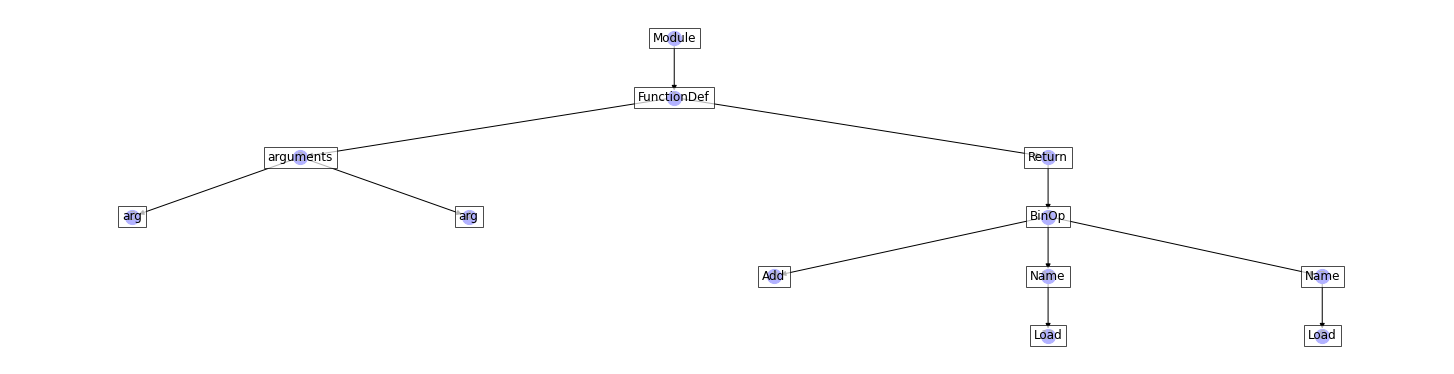

In [6]:
nx_graph = dgl_graph.to_networkx()

pos = hierarchy_pos(nx_graph, 0, width=2.)
plt.figure(figsize=(20,5))
nx.draw(nx_graph, pos, with_labels=True, node_size=200, node_color="blue", edge_color="black")
nx.draw_networkx_labels(
    nx_graph, 
    pos, 
    {
        i: val for i, val in enumerate(idx2type.iloc[graph_dict["node_feat"][:, 0]].type)
    }, 
    bbox={"ec": "k", "fc": "white", "alpha": 0.7}
)
plt.show()

In [31]:
augment_edge(dgl_graph)

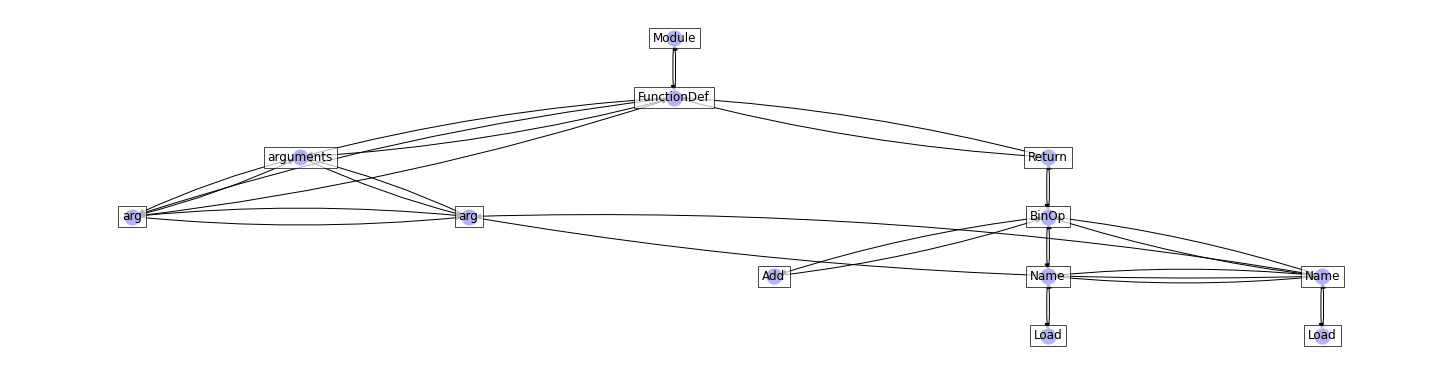

In [13]:
nx_graph = dgl_graph.to_networkx()

plt.figure(figsize=(20,5))
nx.draw(
    nx_graph, 
    pos, 
    with_labels=True, node_size=200, node_color="blue", edge_color="black",
    connectionstyle='arc3, rad=0.05', 
    arrowsize = 10, linewidths = 2
)
nx.draw_networkx_labels(
    nx_graph, 
    pos, 
    {
        i: val for i, val in enumerate(idx2type.iloc[graph_dict["node_feat"][:, 0]].type)
    }, 
    bbox={"ec": "k", "fc": "white", "alpha": 0.7},
)
plt.show()

In [57]:
state_dict = torch.load("models/gcn_dropout_longer/model.pt", map_location=torch.device('cpu'))
model = MethodNamePredictor(5002, 5, ASTNodeEncoder(300, 98, 10030, 20), gnn_type="gcn")
model.load_state_dict(state_dict)

<All keys matched successfully>

In [64]:
predictions = model(train_loader.dataset[0][0])

tensor([[ 0.0000,  0.0000,  0.0000,  ..., -0.0000, -0.0122, -0.0140],
        [-0.0172, -0.1380,  0.0194,  ...,  0.0419, -0.0000,  0.0665],
        [-0.0000, -0.1007, -0.0651,  ...,  0.0000, -0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0004, -0.0000,  ..., -0.0000, -0.0000, -0.0000],
        [-0.0049, -0.0895,  0.0000,  ...,  0.0073,  0.0020,  0.0160],
        [ 0.0000, -0.0000, -0.0211,  ..., -0.0000, -0.0011, -0.0000]],
       grad_fn=<MulBackward0>)
tensor([[-1.5106e-03, -3.4293e-03, -5.7988e-04,  6.7139e-04,  1.7677e-03,
         -1.9770e-03,  1.9973e-03,  1.3948e-03, -1.4615e-04,  2.0994e-03,
         -2.5171e-03, -1.3888e-03, -9.8800e-04,  1.3000e-03, -6.9719e-04,
          1.4887e-03, -2.0686e-03, -5.9656e-04, -6.4292e-04, -1.1335e-03,
         -1.3566e-03,  4.0834e-03, -8.0020e-04, -1.1605e-03, -9.3656e-04,
         -2.9591e-03, -2.9633e-04,  1.5499e-03,  2.2672e-03,  6.9140e-04,
          1.2381e-03,  7.5285e-04,  1.3205e-03, -4.8899e-04, -6.7717e-04,
          1.2098e

In [56]:
predictions[0].size()

torch.Size([1, 5002])

In [51]:
for tensor in predictions:
    idxs = tensor.argsort(descending=True)[0][:3]
    for idx in idxs:
        print(idx2vocab[idx], tensor[0, idx].item(), end=" ")
    print()

get 4.996817111968994 __UNK__ 4.864140033721924 set 3.579315662384033 
__EOS__ 5.5341925621032715 __UNK__ 5.088615417480469 to 3.2071738243103027 
__EOS__ 6.505235195159912 __UNK__ 3.9586174488067627 to 2.4648280143737793 
__EOS__ 7.114027976989746 __UNK__ 2.888357400894165 name 1.5413541793823242 
__EOS__ 7.500490665435791 __UNK__ 2.078481674194336 name 0.7640278935432434 
